# Preparation

## Introduction

Increasing number of people pay attention to health issue nowadays thus body fat percentage, as a measurement of health outcomes has been attached great importance to naturally. Unlike weight and height which can be measured easily, it is difficult to find a convenient and economical way to measure body fat percentage accurately. Therefore, we want to build an appropriate model to estimate the body fat percentage using clinically available measurements such as various body circumference data.

## Background information about the data

The data contains 252 observations of 16 variables: body fat(%), density(gm/cm^3), age(years), weight(lbs), height(inches), adioposity(bmi) and the circumference(cm) of neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm and wrist.
Density is determined from underwater weighing, which is quite cumbersome. Besides, we have Siri's equation which tells the linear relation between body fat percentage and density: $B = \frac{1}{D}\times\frac{ab}{a-b} - \frac{b}{a-b}$.                                            
Note: D = Body Density $(gm/cm^{3})$, A = proportion of lean body tissue, B = proportion of fat tissue $(A+B=1)$, a = density of lean body tissue $(gm/cm^{3})$, b = density of fat tissue $(gm/cm^{3})$.                                                                               
By searching in google, we find two body fat calculators: one contains weight, height, age, the circumference of waist, hip, neck while the other needs the information about weight, the circumference of waist, wrist, hip and forearm. Two calculators both include information about weight, waist circumference, hip circumference which we think may be important before we build the model. We don't have waist circumference but we think the part of body to measure waist circumference is almost the same part to measure abdomen circumference. Thus, it's fine to consider circumference of waist is the same as that of abdomen.


## Data cleaning

  First, from Siri's equation we learn that there is a linear relation between the percentage of body fat and density, so we draw the plot (body fat percentage vs 1/density).

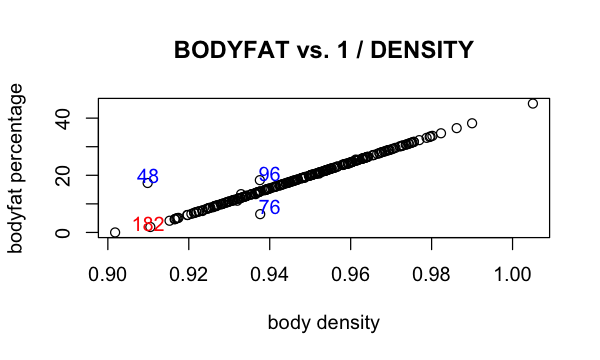

In [41]:
library(IRdisplay)
display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

library(IRdisplay)

layout(1)
rm(list = ls())

# read the data
dat = read.csv("BodyFat.csv", row.names = 1)

# find some abnormal points which bodyfat does not have a linear relationship of 1 / density
library(repr)
options(repr.plot.width=5, repr.plot.height=3)
plot(y = dat$BODYFAT, x = 1 / dat$DENSITY, ylab = "bodyfat percentage", xlab = "body density", 
     main = "BODYFAT vs. 1 / DENSITY")
text(0.91,20,"48",col = "blue")
text(0.94,20.5,"96",col = "blue")
text(0.94,9,"76",col = "blue")
text(0.91,3,"182",col = "red")

The straight line in the plot indicates the Siri's equation but there are three points off the line. We all know that body fat percentage is calculated by density which is determined under the water. The reason why it occurs these three points may be the mistakes made when reporting and transferring density or body fat data into database. However, we cannot determine where the mistakes come from because both density data and body fat data are the potential source. Thus, we have to remove the 48th, the 96th and the 76th observation.                        
Second, by looking at the maximum and minimum of each variable, we find several observations weird. One of which is the 182nd observation whose body fat percentage is zero, which is physically impossible. After calculating body fat percentage using Siri's equation given the value of density, the value becomes negative. We can remove this observation too.           
Body fat percentage of the 216th observation is 45 (re-calculate by the equation is 47) which is high, but the value of weight and other body circumferences are large too. Although this man is obesity and may have many diseases, we think it reasonable.

In [11]:
print(dat[216, ])

    BODYFAT DENSITY AGE WEIGHT HEIGHT ADIPOSITY NECK CHEST ABDOMEN   HIP THIGH
216    45.1   0.995  51    219     64      37.6 41.2 119.8   122.1 112.8  62.5
    KNEE ANKLE BICEPS FOREARM WRIST
216 36.9  23.6   34.7    29.1  18.4


The 39th man weighs 363 lbs which is huge while the height of 42nd observation is 30 inches which is short. These two observations may be the potential outliers. We do the regression on body fat percentage and check the cook's distance. We use the rule of thumb that classifying anything above 4/(n-p) as leverage points. The 39th and 42nd points are actually high leverage points and we can remove them.

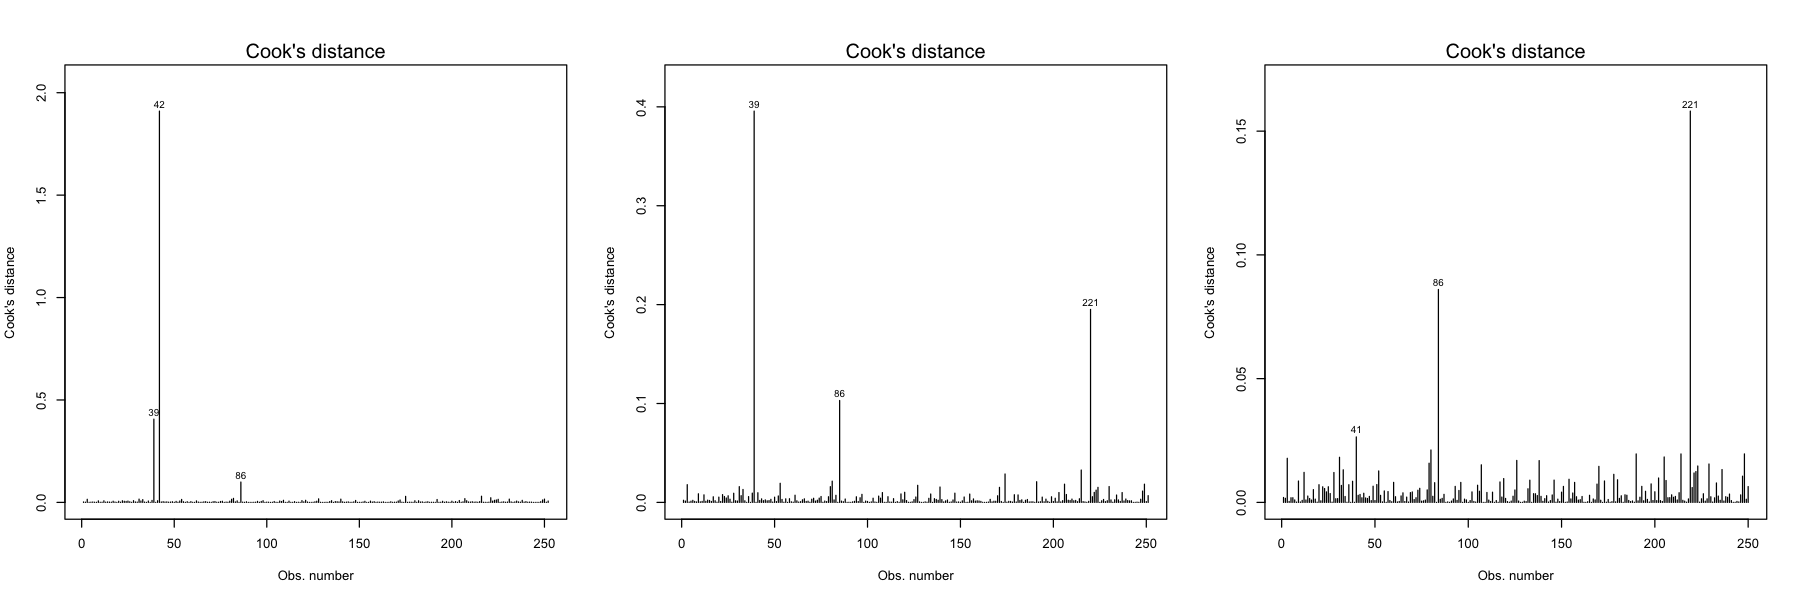

In [22]:
# remove the DENSITY variable
dat = dat[, -2]
model_cook1 <- lm(BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST, data = dat)
model_cook2 <- lm(BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST, data = dat[-42,])
model_cook3 <- lm(BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST, data = dat[-c(39,42),])
layout(matrix(1:3, nrow = 1, byrow = TRUE))
options(repr.plot.width=15, repr.plot.height=5)
plot(model_cook1, which = 4)
plot(model_cook2, which = 4)
plot(model_cook3, which = 4)

After removing them, we can see it occurs new high leverage points. However, when we check them one by one, there is nothing abnormal. We just retain all the remaining data.

In [23]:
dat = dat[c(-39, -42, -48, -96, -76, -182), ]
rownames(dat) = NULL
# find some points with high cook's distance
model = lm(BODYFAT ~ ., data = dat)
layout(1)
#plot(model, which = 4)
# perform a outlier test

library(car, quietly = TRUE)
library(faraway)
outlierTest(model)


No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferonni p
218 -2.592132           0.010149           NA

# Model Fitting

Motivation: We want to find a model which is simply, accurate and robust. The first model come to our mind is linear regression model which is simply and easy to understand. If the linear trend is obvious, the outcome must be great. Therefore, we draw the plot of body fat with each variable to check the linearity. There are linear relations between body fat and some of variables except height and ankle.                                             
Then we consider the necessity of do the transform. After we do the Box-Cox transform, the lambda is around 1 when log-likelihood reaches its max so that we don't have to do the transform.                                                                             
Assumptions: The explanatory variables are related linearly to the response.
The errors have constant variance and they are independent and normally distributed.          
Variable selection: We want to estimate body fat percentage as accurate as possible, so we should compare the results of each model and do cross-validation. The best model is the one has smallest mean square error. We use several ways to fit the model: AIC, BIC criteria (each criteria we use forward, backward, stepwise selection), Mallow's Cp and lasso.

In [24]:
# print the table of all methods and their MSEs
print(data.frame(method_name = c("full model", "backward selection w/ aic", "forward selection w/ aic",
                                 "backward selection w/ bic", "forward selection w/ bic", "Mallow's Cp", 
                                 "Lasso"),
                 test_set_MSE = c("16.88633", "16.07167", "16.05795", "16.32701", "16.15140", "16.04617", "16.10306")))


                method_name test_set_MSE
1                full model     16.88633
2 backward selection w/ aic     16.07167
3  forward selection w/ aic     16.05795
4 backward selection w/ bic     16.32701
5  forward selection w/ bic     16.15140
6               Mallow's Cp     16.04617
7                     Lasso     16.10306


Mallow's Cp gives us the model with smallest mean square error. The model contains six variables: age, height, abdomen, wrist, chest and biceps. In order to obtain a simpler model, we do anova test so that we can move chest and biceps with a little bit increase in mean square error.                                                                            
ANOVA Test                                                                              
bodyfat~age+height+chest+abdomen+wrist vs. bodyfat~age+height+chest+abdomen+biceps+wrist

In [25]:
model_cp = BODYFAT ~ AGE + HEIGHT + CHEST + ABDOMEN +  BICEPS + WRIST
cp_lm = lm(model_cp, dat)

# use the Mallow's Cp
#summary(cp_lm)

# remove one variable, BICEPS
model_cp_2 = BODYFAT ~ AGE + HEIGHT + CHEST + ABDOMEN + WRIST
cp_lm_2 = lm(model_cp_2, dat)
#summary(cp_lm_2)
anova(cp_lm_2, cp_lm)


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
240,3729.111,NA,NA,NA,NA
239,3691.710,1,37.40081,2.421316,0.1210175



bodyfat~age+height+abdomen+wrist vs. bodyfat~age+height+chest+abdomen+wrist

In [26]:
# remove one variable, CHEST
model_cp_3 = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST
cp_lm_3 = lm(model_cp_3, dat)
#summary(cp_lm_3)
#anova(cp_lm_3, cp_lm)
anova(cp_lm_3, cp_lm_2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
241,3772.903,NA,NA,NA,NA
240,3729.111,1,43.79283,2.818441,0.09448831


The variables we choose partly reflect the prior information we obtain from the body fat percentage calculator. We don't have weight and hip variables which exist in both calculators because weight and hip have relation with abdomen. The covariance between weight and abdomen is 0.87 while the covariance between hip and abdomen is 0.86. Thus, we choose abdomen instead of these two variables to predict body fat percentage.

# Model Evaluation

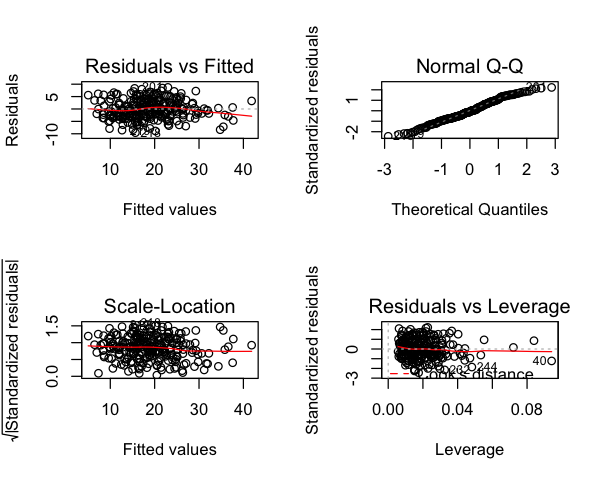

In [36]:
layout(matrix(1:4, byrow = TRUE, nrow = 2))
library(repr)
options(repr.plot.width=5, repr.plot.height=4)
plot(cp_lm_3)

## Model Diagnostics:

From the residual plot we can see that the residuals have the same various (the number of larger value points is small so that it looks sparse). However, the normality seems to be violated.

In [20]:
summary(cp_lm_3)


Call:
lm(formula = model_cp_3, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5622 -2.8331 -0.3255  3.0420  8.7059 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.05418    7.68007   0.528   0.5981    
AGE          0.04856    0.02215   2.192   0.0293 *  
HEIGHT      -0.28949    0.11385  -2.543   0.0116 *  
ABDOMEN      0.71150    0.03155  22.552  < 2e-16 ***
WRIST       -1.79451    0.38131  -4.706 4.26e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.957 on 241 degrees of freedom
Multiple R-squared:  0.7339,	Adjusted R-squared:  0.7294 
F-statistic: 166.1 on 4 and 241 DF,  p-value: < 2.2e-16


All of our variables are significant according to p-values and standard errors for each variable is small. The coefficients of age (0.05), abdomen (0.7) is positive which goes well with our life experience. The coefficients of height (-0.3) and wrist (-1.8) is negative. Contrary to common belief, the wrist circumference is larger means body fat percentage is lower given other conditions the same. Suppose that a man who wants to keep fit and exercise a lot, especially do the sports which increase the strength of arms. There will be much muscle and the bones will be bigger which increase wrist circumference. For example, arms full of muscle means strength to a boxer but his body fat is low due to the daily exercise.         
Suppose the null hypothesis is that age, height, abdomen circumference and wrist circumference are all unrelated with the body fat percentage. According to p-values we can reject the null hypothesis also the F test indicates this. There is a linear relationship between age, height, abdomen circumference and wrist circumference with body fat percentage.
Age, height, abdomen, wrist explains about 73% the variation of body fat percentage.
The confidence intervals are listed below.

In [30]:
confint(cp_lm_3)

,2.5 %,97.5 %
(Intercept),-11.074442024,19.18280854
AGE,0.004926875,0.09218620
HEIGHT,-0.513762515,-0.06522341
ABDOMEN,0.649356280,0.77364973
WRIST,-2.545628345,-1.04338296


## Laymen's interpretation

Body fat percentage comes from 5% age plus 0.7 abdomen, subtract 0.3 height and 1.8 wrist, plus 4.                                                                                       
Example usage:                                                                              
Suppose that a male whose age is 23 measures his height (73.25 inch), wrist circumference(17 cm), abdomen circumference(95 cm). His body fat percentage would be around 19%. There is a 95% probability that his body fat percentage is between 11% and 27%.

## Strengths and Weaknesses

Strengths:                                                                                     
1.The model is simple and easy to understand. All the variables needed for prediction is convenient to measure.                                                                 
2.The model is robust that each variable has single definite value.                           
3.The model is somewhat accurate as the adjusted R-squared is 72.94%, and 95% prediction interval of a new guy's bodyfat(%) is between predicted value $\mp$ 8.                         
4.We use cross-validation to select variables so that we can avoid overfitting.            

Weaknesses:                                                                                   
1.We may ignore the interaction between variables or high order terms.                       
2.The model is efficient and accurate only when we want to predict male whose age is between 20 to 60.                                                                                     
3.Normality and homoskedasticity assumptions may not satisfy well.

## Conclusion

Overall, our model gives a simple way to predict body fat percentage which is easy to understand and accurate. However, the number of data is small which will lead to some problems. The assumption of normality is violated.

# Duties

Cheng Lu: Analyzing raw data and data cleaning of slides and jupyter notebook summary.        
Zong Guo: Model selection and variable selection of slides and jupyter notebook summary.      
Wenyan Zhou: Analysis of the model and giving conclusion, strengths and weaknesses, usage of slides and jupyter notebook summary.

# Reference

[1]Tiago V. Barreira, Deirdre M. Harrington, Amanda E. Staiano, et al. Body Adiposity Index, Body Mass Index and Body Fat in White and Black Adults. JAMA. 2011 Aug 24; 306(8): 828-830.   
[2]Camhi SM, Bray GA, Bouchard C, et al. The relationship of waist circumference and BMI to visceral, subcutaneous, and total body fat: sex and race differences. Obesity (Silver Spring) 2011;19(2):402-408.                                                                          
[3]Two body fat calculators:                                                                   
https://www.active.com/fitness/calculators/bodyfat                                            
http://bmi-calories.com/body-fat-percentage-calculator.html